In [1]:
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import time
tf.random.set_seed(0)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-wpvk5wmo because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# 이미지
이 문서에서는 GAN을 이용하여 MNIST의 데이터와 비슷한 이미지를 생성하는 모델을 다룬다.

In [2]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5

# GAN
GAN은 generator와 discriminator가 서로 경쟁하며 학습하여 생성모델을 학습하는 네트워크이다.

## Generator
임의의 크기가 100인 벡터로부터 (28, 28, 1) 크기의 이미지를 생성하는 모델이다.

In [3]:
def build_generator():
    input = keras.layers.Input((100,))
    x = keras.layers.Dense(7 * 7 * 256, use_bias=False)(input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Reshape((7, 7, 256))(x)
    x = keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
  
    output = keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    return keras.Model(input, output)

In [4]:
generator = build_generator()
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512   

## Discriminator
(28, 28, 1) 크기의 이미지를 입력받아 해당이미지가 실제 이미지인지 generator가 생성한 이미지인지 구분하는 모델이다.

In [5]:
def build_discriminator():
    input = keras.layers.Input((28, 28, 1))
    x = keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Flatten()(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(input, output)

In [6]:
discriminator = build_discriminator()
discriminator.compile(optimizer=keras.optimizers.Adam(0.0001), loss='binary_crossentropy')
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0   

## GAN
Generator와 discriminator를 이어붙여 GAN을 구성한다. 이때, `discriminator`를 학습 불가능하게 설정하는 것은 `gan`을 이용해서는 `generator`만 학습하기 때문이다.

In [7]:
gan_input = keras.layers.Input((100,))
generated = generator(gan_input)
validity = discriminator(generated)

gan = keras.Model(gan_input, validity)
discriminator.trainable = False
gan.compile(optimizer=keras.optimizers.Adam(0.0001), loss='binary_crossentropy')
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Functional)           (None, 28, 28, 1)         2330944   
_________________________________________________________________
model_1 (Functional)         (None, 1)                 212865    
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


학습 전 generator를 이용하여 생성한 이미지이다.

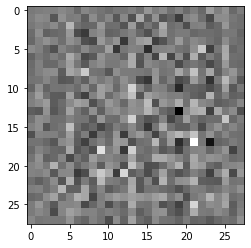

In [8]:
z = tf.random.normal([1, 100])
img = generator(z, training=False)
plt.imshow(img[0, :, :, 0] * 127.5 + 127.5, cmap=plt.cm.gray)
plt.show()

## 학습

In [9]:
BATCH_SIZE = 256
EPOCHS = 50

학습은 앞서 로드한 MNIST 데이터셋을 이용한다. MNIST 데이터를 임의로 섞고 `BATCH_SIZE`개씩 쪼갠다.

In [10]:
train_set = tf.data.Dataset.from_tensor_slices(x_train).shuffle(len(x_train)).batch(BATCH_SIZE)

학습이 진행됨에 있어서 동일한 입력을 가지고 매 epoch마다 생성모델의 학습정도를 확인할 것이다.

In [11]:
test_z = tf.random.normal([10, 100])

학습은 discriminator와 generator 각각 진행한다. Discriminator는 실제 이미지와 generator가 생성해낸 이미지를 잘 구분하도록 학습되고, generator는 discriminator를 속이도록 학습된다.

Time for epoch 50 is 20.020480155944824 sec - d_loss: 1.3300786647390812 g_loss: 0.8134486502789436


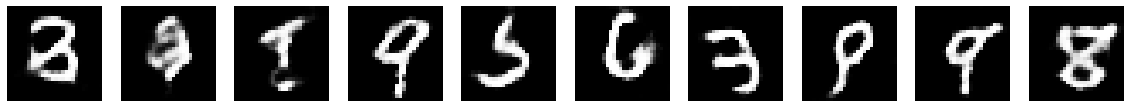

In [12]:
for epoch in range(EPOCHS):
    start = time.time()
    d_losses = []
    g_losses = []
    for images in train_set:
        # generate label
        batch_size = len(images)
        label_real = tf.ones((batch_size, 1))
        label_fake = tf.zeros_like(label_real)

        # train discriminator
        z = tf.random.normal((batch_size, 100))
        generated_image = generator.predict(z)
        d_loss_real = discriminator.train_on_batch(images, label_real)
        d_loss_fake = discriminator.train_on_batch(generated_image, label_fake)
        d_loss = d_loss_real + d_loss_fake
        d_losses.append(d_loss)

        # train generator
        z = tf.random.normal((batch_size, 100))
        g_loss = gan.train_on_batch(z, label_real)
        g_losses.append(g_loss)
    # show progress
    display.clear_output(wait=True)
    print ('Time for epoch {} is {} sec - d_loss: {} g_loss: {}'.format(epoch + 1, time.time()-start, np.mean(d_losses), np.mean(g_losses)))
    generated_images = generator.predict(test_z)
    plt.figure(figsize=(20, 2))
    for i, img in enumerate(generated_images):
        plt.subplot(1, 10, i + 1)
        plt.imshow(img[:, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

# Conditional-GAN
Generator가 임의의 이미지를 생성하는 것이 아니라, 특정 조건의 이미지를 생성하도록 할 수도 있다.
아래는 특정 숫자를 생성하는 모델을 학습하는 것이다.
네트워크의 입력부분을 제외하고, 나머지 부분은 앞서 다룬 GAN과 같다.

## Generator
입력으로 하나의 랜덤벡터와 생성하고자 하는 라벨을 받는다.

In [13]:
def build_labeled_generator():
    latent = keras.layers.Input((100,))
    label = keras.layers.Input((1,), dtype='int32')
    label_embeded = keras.layers.Embedding(10, 100)(label)
    input = keras.layers.multiply([latent, label_embeded])
    
    x = keras.layers.Dense(7 * 7 * 256, use_bias=False)(input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Reshape((7, 7, 256))(x)
    x = keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)

    x = keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
  
    output = keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    return keras.Model([latent, label], output)

In [14]:
labeled_generator = build_labeled_generator()
labeled_generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        input_5[0][0]                    
__________________________________________________________________________________________________
multiply (Multiply)             (None, 1, 100)       0           input_4[0][0]                    
                                                                 embedding[0][0]            

## Discriminator
이미지 하나와 해당 이미지의 라벨을 받는다.
Generator와 마찬가지로 입력부분을 제외하고는 기존과 같다.

In [15]:
def build_labeled_discriminator():
    image = keras.layers.Input((28, 28, 1))
    label = keras.layers.Input((1,), dtype='int32')
    label_embeded = keras.layers.Embedding(10, 28 * 28)(label)
    label_embeded = keras.layers.Reshape((28, 28, 1))(label_embeded)
    input = keras.layers.multiply([image, label_embeded])

    x = keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Flatten()(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    return keras.Model([image, label], output)

In [16]:
labeled_discriminator = build_labeled_discriminator()
labeled_discriminator.compile(optimizer=keras.optimizers.Adam(0.0001), loss='binary_crossentropy')
labeled_discriminator.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 784)       7840        input_7[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 28, 28, 1)    0           embedding_1[0][0]                
____________________________________________________________________________________________

## GAN
Generator와 discriminator를 이용하여 GAN을 구성한다.
이때도, 입력에 주의하여야 한다.

In [17]:
gan_input = keras.layers.Input((100,))
label_input = keras.layers.Input((1,), dtype='int32')
generated = labeled_generator([gan_input, label_input])
validity = labeled_discriminator([generated, label_input])

labeled_gan = keras.Model([gan_input, label_input], validity)
labeled_discriminator.trainable = False
labeled_gan.compile(optimizer=keras.optimizers.Adam(0.0001), loss='binary_crossentropy')
labeled_gan.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
model_3 (Functional)            (None, 28, 28, 1)    2331944     input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
model_4 (Functional)            (None, 1)            220705      model_3[0][0]              

## 학습
앞서와 다르게, 이미지와 해당이미지의 라벨(`y_train`)을 같이 제공해야 한다.

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(BATCH_SIZE)

학습이 진행됨에 있어서 동일한 입력을 가지고 매 epoch마다 생성모델의 학습정도를 확인할 것이다.
이때도 마찬가지로, 라벨을 지정해야 한다.

In [19]:
test_z = tf.random.normal([10, 100])
test_label = tf.expand_dims(tf.range(10), axis=-1)

학습은 앞서와 같이 진행된다. 다만 각 네트워크의 입력에 라벨이 추가된다는 것만 주의하자.

Time for epoch 50 is 23.91319966316223 sec - d_loss: 1.3838456501352026 g_loss: 0.6932789939515134


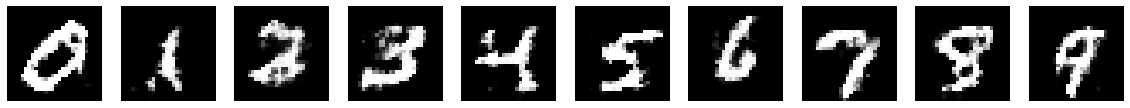

In [20]:
for epoch in range(EPOCHS):
    start = time.time()
    d_losses = []
    g_losses = []
    for images, labels in train_dataset:
        # generate label
        batch_size = len(images)
        label_real = tf.ones((batch_size, 1))
        label_fake = tf.zeros_like(label_real)

        # train discriminator
        z = tf.random.normal((batch_size, 100))
        generated_image = labeled_generator.predict([z, labels])
        d_loss_real = labeled_discriminator.train_on_batch([images, labels], label_real)
        d_loss_fake = labeled_discriminator.train_on_batch([generated_image, labels], label_fake)
        d_loss = d_loss_real + d_loss_fake
        d_losses.append(d_loss)

        # train generator
        z = tf.random.normal((batch_size, 100))
        g_loss = labeled_gan.train_on_batch([z, labels], label_real)
        g_losses.append(g_loss)
    # show progress
    display.clear_output(wait=True)
    print ('Time for epoch {} is {} sec - d_loss: {} g_loss: {}'.format(epoch + 1, time.time()-start, np.mean(d_losses), np.mean(g_losses)))
    generated_images = labeled_generator.predict([test_z, test_label])
    plt.figure(figsize=(20, 2))
    for i, img in enumerate(generated_images):
        plt.subplot(1, 10, i + 1)
        plt.imshow(img[:, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()